In [99]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import math
from pathlib import Path
import random
from glob import glob

from os.path import join
import os.path as osp

import cv2 as cv
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import dlib

sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.models.bbox import BBox
from app.utils import file_utils, im_utils, draw_utils
from app.processors import face_detector

In [308]:
# set proto/model filepaths
fp_prototxt_apparent = join(cfg.DIR_MODELS_CAFFE, 'age_apparent', 'age.prototxt')
fp_model_apparent = join(cfg.DIR_MODELS_CAFFE, 'age_apparent', 'dex_imdb_wiki.caffemodel')

fp_prototxt_real = join(cfg.DIR_MODELS_CAFFE, 'age_real', 'age.prototxt')
fp_model_real = join(cfg.DIR_MODELS_CAFFE, 'age_real', 'dex_chalearn_iccv2015.caffemodel')

fp_prototxt_gender = join(cfg.DIR_MODELS_CAFFE, 'gender', 'gender.prototxt')
fp_model_gender = join(cfg.DIR_MODELS_CAFFE, 'gender', 'gender.caffemodel')

In [309]:
# create dnn net
net_apparent = cv.dnn.readNetFromCaffe(fp_prototxt_apparent, fp_model_apparent)
net_real = cv.dnn.readNetFromCaffe(fp_prototxt_real, fp_model_real)
net_gender = cv.dnn.readNetFromCaffe(fp_prototxt_gender, fp_model_gender)

In [146]:
# create face detector
detector = face_detector.DetectorDLIBCNN()

In [ ]:
# get list of images
dir_in = '/data_store_hdd/datasets/people/lfw/media/original/'
fp_ims = glob(join(dir_in, '**/*.jpg'), recursive=True)

In [310]:
def predict(im, net):
  dnn_size = (224,224)
  dnn_mean = (104.0, 177.0, 123.0)
  blob = cv2.dnn.blobFromImage(cv.resize(im_face_crop, dnn_size), 1.0, dnn_size, dnn_mean)
  net.setInput(blob)
  outputs = net.forward()[0]
  return outputs

loading /data_store_hdd/datasets/people/lfw/media/original/Sally_Ride/Sally_Ride_0002.jpg
[0.87139773 0.12860227]
real: 24.044405392869123, apparent: 27.50983550487581
gender: f, score: 87.14


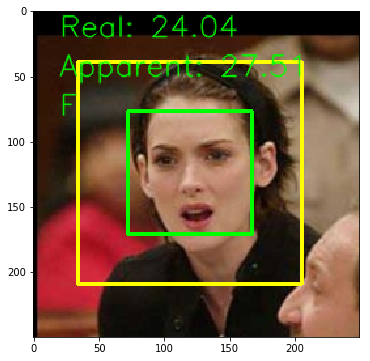

In [318]:
fp_im = np.random.choice(fp_ims)
print(f'loading {fp_im}')
fp_im = '/data_store_hdd/datasets/people/lfw/media/original/Winona_Ryder/Winona_Ryder_0012.jpg'
#fp_im = '/home/adam/Pictures/imdb_01.png'
im = cv.imread(fp_im)
bboxes = detector.detect(im, largest=True)
bbox = bboxes[0]
dim = im.shape[:2][::-1]
bbox_dim = bbox.to_dim(dim)

# expand bbox by 40% according to https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
bbox_dim_exp = bbox_dim.expand_dim( int(0.4*bbox_dim.width), dim)
roi = bbox_dim_exp.to_xyxy()
im_face_crop = im[roi[1]:roi[3], roi[0]:roi[2]]  # isolate face roi

preds_real = predict(im_face_crop, net_real)
preds_apparent = predict(im_face_crop, net_apparent)
preds_gender = predict(im_face_crop, net_gender)

print(preds_gender)
gender = 'f' if preds_gender[0] > 0.5 else 'm'
gender_score = preds_gender[0] if gender is 'f' else preds_gender[1]

ages = np.arange(0, 101).reshape(101, 1)
# take dot product and make a single list out of lists
predicted_age_apparent = preds_apparent.dot(ages).flatten()[0]
predicted_age_real = preds_real.dot(ages).flatten()[0]
print(f'real: {predicted_age_real}, apparent: {predicted_
      age_apparent}')
print(f'gender: {gender}, score: {100*gender_score:.2f}')

# draw
im_face = im.copy()
draw_utils.draw_bbox(im_face, bbox_dim, color=(0,255,0))
draw_utils.draw_bbox(im_face, bbox_dim_exp, color=(0,255,255))
draw_utils.draw_text(im_face, (20,20), f'Real: {predicted_age_real:.2f}')
draw_utils.draw_text(im_face, (20,50), f'Apparent: {predicted_age_apparent:.2f}')
draw_utils.draw_text(im_face, (20,80), f'{gender.upper()}')

# plot
plt.figure(figsize=(6,6))
plt.imshow(cv.cvtColor(im_face, cv.COLOR_BGR2RGB))

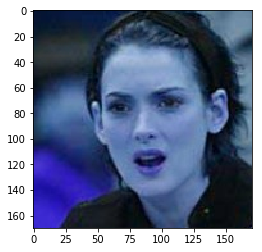

In [307]:
plt.imshow(im_face_crop)
cv.FO

In [180]:
print(len(preds))
print(preds[0])

101
0.00034814802


In [184]:
age = sum([(float(age) * preds[age_idx]) for age_idx, pred in enumerate(preds)])
print(age)

3.0000010269578485
